In [26]:
import re
import random
import time
from statistics import mode

from PIL import Image
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

import os
from transformers import BertModel, BertTokenizer
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
print_cnt = 0


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def process_text(text):
    # lowercase
    text = text.lower()

    # 数詞を数字に変換
    num_word_to_digit = {
        'zero': '0', 'one': '1', 'two': '2', 'three': '3', 'four': '4',
        'five': '5', 'six': '6', 'seven': '7', 'eight': '8', 'nine': '9',
        'ten': '10'
    }
    for word, digit in num_word_to_digit.items():
        text = text.replace(word, digit)

    # 小数点のピリオドを削除
    text = re.sub(r'(?<!\d)\.(?!\d)', '', text)

    # 冠詞の削除
    text = re.sub(r'\b(a|an|the)\b', '', text)

    # 短縮形のカンマの追加
    contractions = {
        "dont": "don't", "isnt": "isn't", "arent": "aren't", "wont": "won't",
        "cant": "can't", "wouldnt": "wouldn't", "couldnt": "couldn't"
    }
    for contraction, correct in contractions.items():
        text = text.replace(contraction, correct)

    # 句読点をスペースに変換
    text = re.sub(r"[^\w\s':]", ' ', text)

    # 句読点をスペースに変換
    text = re.sub(r'\s+,', ',', text)

    # 連続するスペースを1つに変換
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def is_color_question(text):
    words = ['what color', 'what _colors']
    return int(any((w in text) for w in words))

def is_closed_question(text):
    words1 = ['are you', 'can you', 'will you', 'could you', 'aren\'t you']
    return int(text[:1] == 'is' or text[:3] == 'does' or (text.find('you') >= 0) and any((w in text) for w in words1))


# CSVファイルからクラスマッピングを読み込む
def load_class_mapping():
    df = pd.read_csv('class_mapping.csv')
    class_mapping = {row['answer']: int(row['class_id']) for index, row in df.iterrows()}
    return class_mapping

# 1. データローダーの作成
class VQADataset(torch.utils.data.Dataset):
    def __init__(self, df_path, image_dir, transform=None, answer=True):
        self.transform = transform  # 画像の前処理
        self.image_dir = image_dir  # 画像ファイルのディレクトリ
        self.df = pd.read_json(df_path)  # 画像ファイルのパス，question, answerを持つDataFrame
        self.df['question'] = self.df['question'].apply(process_text)
        self.df['color'] = self.df['question'].apply(is_color_question)
        self.df['closed'] = self.df['question'].apply(is_closed_question)
        self.answer = answer

        # answerの辞書を作成
        self.answer2idx = load_class_mapping()
        self.idx2answer = {}

        if self.answer:
            # 回答に含まれる単語を辞書に追加
            for answers in self.df["answers"]:
                for answer in answers:
                    word = answer["answer"]
                    word = process_text(word)
                    if word not in self.answer2idx:
                        self.answer2idx[word] = len(self.answer2idx)
            self.idx2answer = {v: k for k, v in self.answer2idx.items()}  # 逆変換用の辞書(answer)

    def update_dict(self, dataset):
        """
        検証用データ，テストデータの辞書を訓練データの辞書に更新する．

        Parameters
        ----------
        dataset : Dataset
            訓練データのDataset
        """
        # self.question2idx = dataset.question2idx
        self.answer2idx = dataset.answer2idx
        # self.idx2question = dataset.idx2question
        self.idx2answer = dataset.idx2answer

    def __getitem__(self, idx):
        """
        対応するidxのデータ（画像，質問，回答）を取得．

        Parameters
        ----------
        idx : int
            取得するデータのインデックス

        Returns
        -------
        image : torch.Tensor  (C, H, W)
            画像データ
        question : torch.Tensor  (vocab_size)
            質問文をone-hot表現に変換したもの
        answers : torch.Tensor  (n_answer)
            10人の回答者の回答のid
        mode_answer_idx : torch.Tensor  (1)
            10人の回答者の回答の中で最頻値の回答のid
        """
        image = Image.open(f"{self.image_dir}/{self.df['image'][idx]}")
        image = self.transform(image)
        
        question = self.df['question'][idx]
        color = self.df['color'][idx]
        closed = self.df['closed'][idx]


        if self.answer:
            answers = [self.answer2idx[process_text(answer['answer'])] for answer in self.df['answers'][idx]]
            mode_answer_idx = mode(answers)  # 最頻値を取得（正解ラベル）

            return image, question, color, closed, torch.Tensor(answers).to(torch.int32), int(mode_answer_idx)
            # return image, question, torch.Tensor(answers), int(mode_answer_idx)

        else:
            return image, question, color, closed

    def __len__(self):
        return len(self.df)

    def __len__(self):
        return len(self.df)

    
    
set_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"

# dataloader / model
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=(-180, 180)),  # random rotation
    transforms.RandomCrop(32, padding=(4, 4, 4, 4), padding_mode='constant'),  # random cropping
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
])
    
train_dataset = VQADataset(df_path="./data/train.json", image_dir="./data/train", transform=transform)
test_dataset = VQADataset(df_path="./data/valid.json", image_dir="./data/valid", transform=transform, answer=False)
test_dataset.update_dict(train_dataset)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=os.cpu_count(), pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=os.cpu_count(), pin_memory=True)
model = VQAModel(n_answer=len(train_dataset.answer2idx)).to(device)


In [40]:
for image, question, color, closed, answers, mode_answer in train_loader:
    image, answers, mode_answer = \
        image.to(device, non_blocking=True), answers.to(device, non_blocking=True), mode_answer.to(device, non_blocking=True)
#     pred = model(image, question, color, closed)
    print(color, closed)
#     loss = criterion(pred, mode_answer.squeeze())

#     answer_counts = torch.zeros(pred.shape, device=image.device)
#     for i in range(pred.shape[0]):
#         for answer in answers[i]:
#             answer_counts[i][answer] += 1

#     print(mode_answer.squeeze())
#     print(pred.shape)
#     print(mode_answer.shape, mode_answer.squeeze().shape)
#     print(answer_counts.shape, answer_counts.squeeze().shape)
    
#     print(F.cross_entropy(pred, mode_answer.squeeze()))
#     loss = F.cross_entropy(pred, answer_counts.squeeze())
#     print(loss)

#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     total_loss += loss.item()
#     total_acc += VQA_criterion(pred.argmax(1), answers)  # VQA accuracy
#     simple_acc += (pred.argmax(1) == mode_answer).float().mean().item()  # simple accuracy
    break

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 0]) tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0])


In [2]:
train_dataset.df["answers"]

0        [{'answer_confidence': 'yes', 'answer': 'beef ...
1        [{'answer_confidence': 'yes', 'answer': 'unans...
2        [{'answer_confidence': 'yes', 'answer': 'grey'...
3        [{'answer_confidence': 'maybe', 'answer': 'lot...
4        [{'answer_confidence': 'yes', 'answer': 'no'},...
                               ...                        
19868    [{'answer_confidence': 'yes', 'answer': 'unans...
19869    [{'answer_confidence': 'yes', 'answer': 'finge...
19870    [{'answer_confidence': 'yes', 'answer': 'hands...
19871    [{'answer_confidence': 'yes', 'answer': 'unans...
19872    [{'answer_confidence': 'maybe', 'answer': 'yes...
Name: answers, Length: 19873, dtype: object

In [80]:
print(train_dataset.df[train_dataset.df["answers"].apply(lambda ls: "unanswerable" in list(map(lambda ls: ls["answer"], ls)))][["question", "answers"]][:20])

                                             question  \
1   maybe it's because you're pushing it down instead   
3   can you tell me if this is like body wash or l...   
4                                         is it paper   
7                                 what device is this   
8                         please tell me what this is   
11                                       what is this   
14                             what's in this package   
16                                 what's in this can   
17                                       what is this   
19                                       what is this   
20                              when does this expire   
23                                       what is this   
24                                  what book is this   
25                           what kind of box is this   
27                can you please tell me what this is   
28                          my routerthe front lights   
29                         you 

In [83]:
print(train_dataset.df[train_dataset.df["answers"].apply(lambda ls: any(w in list(map(lambda ls: ls["answer"], ls)) for w in ['yes', 'no'] ) )][["question", "answers"]][40:60])

                                              question  \
433          could you tell what brand of wine this is   
438                         are these mushrooms edible   
445                  can you read label of this bottle   
459  can you please tell me who this business card ...   
495                 can you tell me what's in this can   
507          can you tell what kind of pills these are   
509                   can you tell me who this is from   
520                    can you see what is in this can   
521                           end of sandstorm is this   
535   and what are your hours or do you work all night   
537               can i use this to wash kitchen floor   
538                   is there picture on this blanket   
542  is text on this page inverted and what page nu...   
545                   can you read what is on this bag   
546                          how do i do are they even   
564                   can you tell me what this can is   
567  can you t

In [66]:
from scipy.stats import mode

answers_series = train_dataset.df["answers"].apply(lambda ls: np.array([e["answer"] for e in ls]))

# numpy 配列から最頻値を求める関数
def get_mode(array):
    vals, counts = np.unique(array, return_counts=True)
    max_index = counts.argmax()
    return vals[max_index]

# 最頻値を格納する新しい Series を作成
mode_series = answers_series.apply(get_mode)

# 最頻値の出現数をカウント
frequency = mode_series.value_counts()

# 結果の表示
print(mode_series)
print(frequency[:30])

0           beef chuck steak
1               unanswerable
2                       grey
3                     lotion
4                         no
                ...         
19868           unanswerable
19869          finger puppet
19870    handsome like daddy
19871           unanswerable
19872                     no
Name: answers, Length: 19873, dtype: object
unanswerable       7279
no                  521
yes                 448
white               291
grey                271
black               237
blue                218
red                 116
brown               106
pink                 90
keyboard             90
green                78
laptop               70
purple               64
dog                  63
phone                51
soup                 50
cell phone           50
yellow               47
coca cola            44
remote               40
coffee               39
lotion               39
nothing              38
wine                 38
corn                 38
computer scre

In [64]:
frequency.value_counts().sort_values()

7279       1
521        1
78         1
448        1
291        1
271        1
237        1
116        1
106        1
218        1
70         1
64         1
31         1
51         1
47         1
44         1
40         1
36         1
63         1
33         1
29         2
90         2
50         2
39         2
37         2
32         2
26         2
22         2
21         2
17         2
24         2
23         3
38         3
27         3
20         4
19         4
11         6
15         7
12         7
16         9
18         9
13        10
14        11
9         20
10        22
8         25
7         33
6         43
5         54
4        117
3        230
2        571
1       4131
Name: answers, dtype: int64

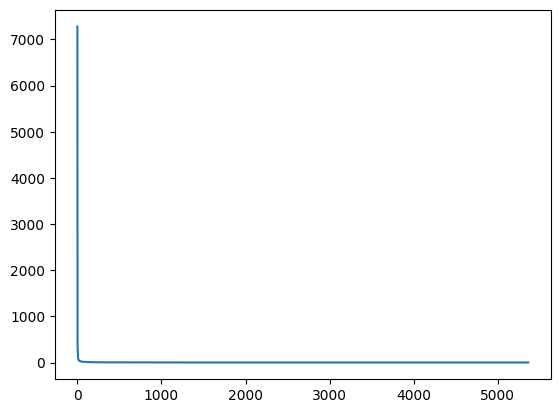

In [58]:
import matplotlib.pyplot as plt

plt.plot(range(len(frequency)), frequency.values)
plt.show()

In [41]:
# 3. モデルのの実装
# ResNetを利用できるようにしておく
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels: int, out_channels: int, stride: int = 1):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        out += self.shortcut(residual)
        out = self.relu(out)

        return out


class BottleneckBlock(nn.Module):
    expansion = 4

    def __init__(self, in_channels: int, out_channels: int, stride: int = 1):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels * self.expansion)
            )

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        out += self.shortcut(residual)
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(self, block, layers):
        super().__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, layers[0], 64)
        self.layer2 = self._make_layer(block, layers[1], 128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], 256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], 512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, 512)

    def _make_layer(self, block, blocks, out_channels, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet50():
    return ResNet(BottleneckBlock, [3, 4, 6, 3])

class VQAModel(nn.Module):
    def __init__(self, n_answer: int):
        super().__init__()

        self.bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
        self.bert_model = BertModel.from_pretrained(
            "bert-base-uncased", torch_dtype=torch.float32, attn_implementation="sdpa"
        )
        # self.bert_model = BertModel.from_pretrained("bert-base-uncased")
        for name, param in self.bert_model.named_parameters():
            if name.startswith('encoder.layer.11'):
                param.requires_grad = True
            else:
                param.requires_grad = False

        self.resnet = ResNet18()

        self.fc = nn.Sequential(
            nn.Linear(1282, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, n_answer)
        )

    def forward(self, image, question, color, closed):
        N = image.shape[0]
        image_feature = self.resnet(image)
        assert image_feature.shape == (N, 512)

        # with torch.no_grad():
        tokens = self.bert_tokenizer(question, return_tensors="pt", padding=True, truncation=True, max_length=512)
        tokens = {k: v.to(image.device) for k, v in tokens.items()}
        question_feature = self.bert_model(**tokens).last_hidden_state[:, 0, :]
        assert question_feature.shape == (N, 768)

        color_features = color.clone().detach().view(N, 1).to(image.device)
        closed_features = closed.clone().detach().view(N, 1).to(image.device)

        x = torch.cat([image_feature, question_feature, color_features, closed_features], dim=1)
        assert x.shape == (N, 1282)
        x = self.fc(x)
        x = torch.nn.functional.softmax(x, dim=1)
        return x



In [ ]:
train_dataset = VQADataset(df_path="./data/train.json", image_dir="./data/train", transform=transform)
test_dataset = VQADataset(df_path="./data/valid.json", image_dir="./data/valid", transform=transform, answer=False)
test_dataset.update_dict(train_dataset)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=os.cpu_count(), pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=os.cpu_count(), pin_memory=True)


In [ ]:

# 4. 学習の実装
def train(model, dataloader, optimizer, criterion, device):
    model.train()

    total_loss = 0
    total_acc = 0
    simple_acc = 0

    start = time.time()
    for image, question, answers, mode_answer in dataloader:
        image, answers, mode_answer = \
            image.to(device, non_blocking=True), answers.to(device, non_blocking=True), mode_answer.to(device, non_blocking=True)

        pred = model(image, question)
        loss = criterion(pred, mode_answer.squeeze())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += VQA_criterion(pred.argmax(1), answers)  # VQA accuracy
        simple_acc += (pred.argmax(1) == mode_answer).float().mean().item()  # simple accuracy

    return total_loss / len(dataloader), total_acc / len(dataloader), simple_acc / len(dataloader), time.time() - start


def eval(model, dataloader, optimizer, criterion, device):
    model.eval()

    total_loss = 0
    total_acc = 0
    simple_acc = 0

    start = time.time()
    for image, question, answers, mode_answer in dataloader:
        image, answers, mode_answer = \
            image.to(device, non_blocking=True), answers.to(device, non_blocking=True), mode_answer.to(device, non_blocking=True)

        pred = model(image, question)
        loss = criterion(pred, mode_answer.squeeze())

        total_loss += loss.item()
        total_acc += VQA_criterion(pred.argmax(1), answers)  # VQA accuracy
        simple_acc += (pred.argmax(1) == mode_answer).mean().item()  # simple accuracy

    return total_loss / len(dataloader), total_acc / len(dataloader), simple_acc / len(dataloader), time.time() - start


def custom_train_collate_fn(batch):
    images = [item[0] for item in batch]
    input_ids = [item[1] for item in batch]
    attention_masks = [item[2] for item in batch]
    answers = [item[3] for item in batch]
    mode_answers = [item[4] for item in batch]

    images = torch.stack(images)

    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=0)
    attention_masks = pad_sequence(attention_masks, batch_first=True, padding_value=0)

    answers = torch.stack(answers)
    mode_answers = torch.stack([torch.tensor(ma) for ma in mode_answers])
    # mode_answers = torch.stack([torch.tensor(item[4], dtype=torch.long) for item in batch])

    return images, input_ids, attention_masks, answers, mode_answers


def custom_test_collate_fn(batch):
    images = [item[0] for item in batch]
    input_ids = [item[1] for item in batch]
    attention_masks = [item[2] for item in batch]

    images = torch.stack(images)

    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=0)
    attention_masks = pad_sequence(attention_masks, batch_first=True, padding_value=0)

    return images, input_ids, attention_masks


class gcn():
    def __init__(self):
        pass

    def __call__(self, x):
        mean = torch.mean(x)
        std = torch.std(x)
        return (x - mean)/(std + 10**(-6))  # 0除算を防ぐ
    

def main():
    global print_cnt
    # deviceの設定
    set_seed(42)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # dataloader / model
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(degrees=(-180, 180)),  # random rotation
        transforms.RandomCrop(32, padding=(4, 4, 4, 4), padding_mode='constant'),  # random cropping
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
        transforms.ToTensor(),
        gcn()
    ])

    train_dataset = VQADataset(df_path="./data/train.json", image_dir="./data/train", transform=transform)
    test_dataset = VQADataset(df_path="./data/valid.json", image_dir="./data/valid", transform=transform, answer=False)
    test_dataset.update_dict(train_dataset)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=os.cpu_count(), pin_memory=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=os.cpu_count(), pin_memory=True)

    model = VQAModel(n_answer=len(train_dataset.answer2idx)).to(device)

    unanswerable_idx = train_dataset.answer2idx.get('unanswerable', None)
    weights = torch.ones(len(train_dataset.answer2idx))
    if unanswerable_idx is not None:
        weights[unanswerable_idx] = 0.001
    # optimizer / criterion
    num_epoch = 5
    criterion = nn.CrossEntropyLoss(weight=weights.to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

    # train model
    for epoch in range(num_epoch):
        train_loss, train_acc, train_simple_acc, train_time = train(model, train_loader, optimizer, criterion, device)
        print(f"【{epoch + 1}/{num_epoch}】\n"
              f"train time: {train_time:.2f} [s]\n"
              f"train loss: {train_loss:.4f}\n"
              f"train acc: {train_acc:.4f}\n"
              f"train simple acc: {train_simple_acc:.4f}")
        print_cnt = 0

    # 提出用ファイルの作成
    model.eval()
    submission = []
    for image, question in test_loader:
        image = image.to(device)
        pred = model(image, question)
        pred = pred.argmax(1).cpu().item()
        submission.append(pred)

    submission = [train_dataset.idx2answer[id] for id in submission]
    submission = np.array(submission)
    torch.save(model.state_dict(), "model.pth")
    np.save("submission.npy", submission)

if __name__ == "__main__":
    main()


In [44]:
aa = BertModel.from_pretrained(
            "bert-base-uncased", torch_dtype=torch.float32, attn_implementation="sdpa"
        )
for name, param in aa.named_parameters():
    print(name, param.shape)

embeddings.word_embeddings.weight torch.Size([30522, 768])
embeddings.position_embeddings.weight torch.Size([512, 768])
embeddings.token_type_embeddings.weight torch.Size([2, 768])
embeddings.LayerNorm.weight torch.Size([768])
embeddings.LayerNorm.bias torch.Size([768])
encoder.layer.0.attention.self.query.weight torch.Size([768, 768])
encoder.layer.0.attention.self.query.bias torch.Size([768])
encoder.layer.0.attention.self.key.weight torch.Size([768, 768])
encoder.layer.0.attention.self.key.bias torch.Size([768])
encoder.layer.0.attention.self.value.weight torch.Size([768, 768])
encoder.layer.0.attention.self.value.bias torch.Size([768])
encoder.layer.0.attention.output.dense.weight torch.Size([768, 768])
encoder.layer.0.attention.output.dense.bias torch.Size([768])
encoder.layer.0.attention.output.LayerNorm.weight torch.Size([768])
encoder.layer.0.attention.output.LayerNorm.bias torch.Size([768])
encoder.layer.0.intermediate.dense.weight torch.Size([3072, 768])
encoder.layer.0.inter